In [2]:
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import GlobalAveragePooling2D as GAP2D
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.optimizers import AdamW, Adam #, Lion
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
from PIL import Image
import numpy as np
from IPython.display import clear_output

np.random.seed(1)
tf.keras.utils.set_random_seed(1)


In [3]:
from matplotlib import pyplot as plt

def charts(history):
    fig, axs = plt.subplots(1, 2)
    axs[0].plot(history.history['loss'])
    axs[0].plot(history.history['val_loss'])
    axs[0].set_title('model loss')
    axs[0].set_ylabel('loss')
    axs[0].set_xlabel('epoch')
    axs[0].legend(['train', 'val'], loc='upper left')

    axs[1].plot(history.history['acc'])
    axs[1].plot(history.history['val_acc'])
    axs[1].set_title('model accuracy')
    axs[1].set_ylabel('accuracy')
    axs[1].set_xlabel('epoch')
    axs[1].legend(['train', 'val'], loc='upper left')

    plt.show()

# Transfering Images from drive to colab disk
this adds a signifficant performance boost

In [4]:
filename_to_name = {
        'n01484850':'shark',
        'n01514859':'chicken',
        'n01530575':'bird',
        'n01614925':'eagle',
        'n01622779':'owl',
        'n01629819':'lizard',
        'n01665541':'turtle',
        'n02114367':'wolf',
        'n02129165':'lion',
        'n02129604':'tiger',
        'n02132136':'grizzly',
        'n02134084':'polar bear',
        'n02389026':'horse',
        'n02504458':'elephant',
        'n02687172':'battleship/carrier'
}

In [5]:
# this is done only for speed

imgnet_path = '/content/drive/MyDrive/ImageNet/'
for ind, files in enumerate(os.listdir(imgnet_path)):
    os.makedirs(f'imagenet/{filename_to_name[files]}')
    for ind1, img in enumerate(os.listdir(imgnet_path+files)):
        q = Image.open(imgnet_path + files + "/" + img)
        q = q.resize((224, 224)).convert('RGB')
        q.save(f'imagenet/{filename_to_name[files]}/{files}{ind1}.jpg')
    print(ind, '/ 15')
    clear_output(wait = True)
print('done')

done


# Creating Data Generator

In [6]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='reflect',
    validation_split=0.1)

train_flow = datagen.flow_from_directory(
            directory='/content/imagenet/',
            target_size=(224, 224),
            color_mode='rgb',
            classes=None,
            class_mode='categorical',
            batch_size=32,
            shuffle=True,
            seed=1,
            subset='training'
            )
val_flow = datagen.flow_from_directory(
            directory='/content/imagenet/',
            target_size=(224, 224),
            color_mode='rgb',
            classes=None,
            class_mode='categorical',
            batch_size=32,
            shuffle=True,
            seed=1,
            subset='validation'
            )

Found 17550 images belonging to 15 classes.
Found 1950 images belonging to 15 classes.


In [7]:
c_indx = train_flow.class_indices
c_indx, c_indx == val_flow.class_indices

({'battleship': 0,
  'bird': 1,
  'chicken': 2,
  'eagle': 3,
  'elephant': 4,
  'grizzly': 5,
  'horse': 6,
  'lion': 7,
  'lizard': 8,
  'owl': 9,
  'polar bear': 10,
  'shark': 11,
  'tiger': 12,
  'turtle': 13,
  'wolf': 14},
 True)

In [8]:
# having this saved in memory is faster than reading from drive every time

val_data = []
val_labl = tf.one_hot(val_flow.classes, 15)

for filename in val_flow.filepaths:
    q = Image.open(filename)
    q = q.resize((224, 224)).convert('RGB')
    val_data.append(np.array(q))

In [9]:
val_data = np.array(val_data)

In [10]:
val_data.shape, val_labl.shape

((1950, 224, 224, 3), TensorShape([1950, 15]))

# Loading The Empty Model

In [11]:
model = EfficientNetB0(
    include_top=True,
    weights=None,
    input_shape=(224, 224, 3),
    classes=15)

lr_schedule = ExponentialDecay(0.01, 500, 0.76)

model.compile(optimizer=AdamW(lr_schedule),
              loss='categorical_crossentropy',
              metrics=['AUC', 'acc'])
# model.summary()

# Fitting

In [12]:
#tf.config.run_functions_eagerly(True)
history = model.fit(train_flow,
                    epochs=15,
                    validation_data=(val_data, val_labl),
                    use_multiprocessing=True,
                    workers=2,
                    verbose=1)

Epoch 1/15
549/549 [==============================] - 324s 488ms/step - loss: 2.7223 - auc: 0.6621 - acc: 0.1389 - val_loss: 3.0177 - val_auc: 0.6457 - val_acc: 0.1256
Epoch 2/15
549/549 [==============================] - 276s 500ms/step - loss: 2.2155 - auc: 0.7859 - acc: 0.2602 - val_loss: 2.1963 - val_auc: 0.7917 - val_acc: 0.2754
Epoch 3/15
549/549 [==============================] - 275s 500ms/step - loss: 1.9461 - auc: 0.8415 - acc: 0.3658 - val_loss: 1.8474 - val_auc: 0.8623 - val_acc: 0.4005
Epoch 4/15
549/549 [==============================] - 274s 496ms/step - loss: 1.6913 - auc: 0.8847 - acc: 0.4542 - val_loss: 1.6117 - val_auc: 0.8973 - val_acc: 0.4533
Epoch 5/15
549/549 [==============================] - 283s 510ms/step - loss: 1.4695 - auc: 0.9135 - acc: 0.5375 - val_loss: 1.3285 - val_auc: 0.9301 - val_acc: 0.5692
Epoch 6/15
549/549 [==============================] - 278s 501ms/step - loss: 1.2564 - auc: 0.9362 - acc: 0.6076 - val_loss: 1.1045 - val_auc: 0.9515 - val_acc:

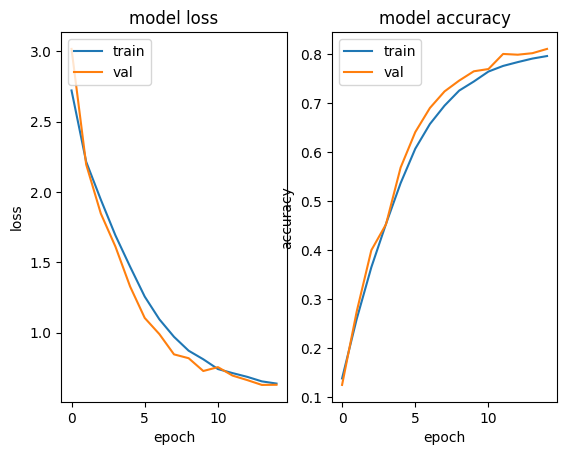

In [14]:
charts(history)

Lets see what happens if we keep going

In [20]:
model.optimizer.learning_rate

<tf.Variable 'current_learning_rate:0' shape=() dtype=float32, numpy=0.00010895272>

In [28]:
lr_schedule = ExponentialDecay(0.0008, 500, 0.9)
model.optimizer = AdamW(lr_schedule)

history1 = model.fit(train_flow,
                    epochs=15,
                    validation_data=(val_data, val_labl),
                    use_multiprocessing=True,
                    workers=2,
                    verbose=1)

Epoch 1/15
549/549 [==============================] - 271s 492ms/step - loss: 0.6131 - auc: 0.9832 - acc: 0.8059 - val_loss: 0.6048 - val_auc: 0.9820 - val_acc: 0.8123
Epoch 2/15
549/549 [==============================] - 272s 493ms/step - loss: 0.6042 - auc: 0.9837 - acc: 0.8093 - val_loss: 0.6023 - val_auc: 0.9823 - val_acc: 0.8149
Epoch 3/15
549/549 [==============================] - 267s 483ms/step - loss: 0.5972 - auc: 0.9835 - acc: 0.8134 - val_loss: 0.5974 - val_auc: 0.9825 - val_acc: 0.8169
Epoch 4/15
549/549 [==============================] - 268s 485ms/step - loss: 0.5990 - auc: 0.9839 - acc: 0.8088 - val_loss: 0.5922 - val_auc: 0.9826 - val_acc: 0.8164
Epoch 5/15
549/549 [==============================] - 266s 482ms/step - loss: 0.5856 - auc: 0.9846 - acc: 0.8115 - val_loss: 0.5930 - val_auc: 0.9823 - val_acc: 0.8159
Epoch 6/15
549/549 [==============================] - 267s 482ms/step - loss: 0.5762 - auc: 0.9851 - acc: 0.8161 - val_loss: 0.5902 - val_auc: 0.9829 - val_acc:

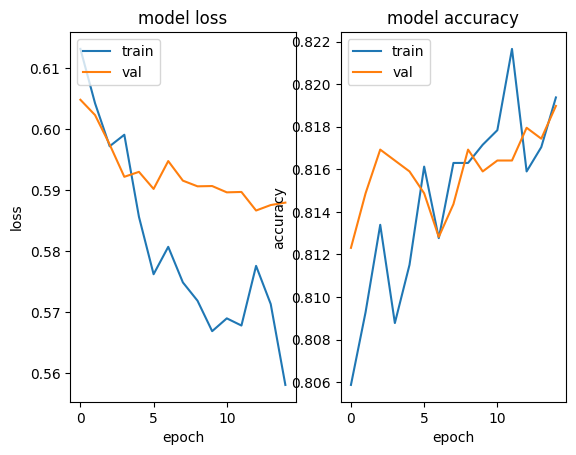

In [29]:
charts(history1)